<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/main/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup enviroment and imports

## Setup

In [ ]:
!pip install -q torch==2.4.0

import os
import torch

os.environ['TORCH'] = torch.__version__
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
print(torch.__version__)

!pip install -q pyg_lib -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_geometric -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torcheval
!pip install -q scikit-plot

2.4.0+cu121


## Imports

In [ ]:
import json
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics as M
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import requests
from zipfile import ZipFile
from io import BytesIO
from typing import Callable
%matplotlib inline

## Other

In [ ]:
data_file = "test"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

metapath = [
    ('team_in_match', 'played_rev', 'player_in_match'),
    ('player_in_match', 'player_instance_rev', 'player'),
    ('player', 'player_instance', 'player_in_match'),
    ('player_in_match', 'played', 'team_in_match'),
    ('team_in_match', 'team_instance_rev', 'team'),
    ('team', 'team_instance', 'team_in_match'),
    ('team_in_match', 'result', 'team_in_match')
]

metapath_homo = [
    ('team', 'team_instance', 'team_in_match'),
    ('team_in_match', 'played_rev', 'player_in_match'),
    ('player_in_match', 'player_instance_rev', 'player')
]

loss_class = [
    torch.nn.L1Loss(),
    torch.nn.MSELoss(),
    torch.nn.CrossEntropyLoss(),
    torch.nn.KLDivLoss()
]

all_used_loss = [
    lambda x, y: F.log_softmax(F.binary_cross_entropy_with_logits(x, y), dim=0),  # ni sprememb med cikli
    lambda x, y: F.binary_cross_entropy_with_logits(x, y),
    lambda x, y: F.mse_loss(x, y),
    lambda x, y: loss_class[0](x, y),
    lambda x, y: loss_class[1](x, y),
    lambda x, y: loss_class[2](x, y),
    lambda x, y: loss_class[3](x, y)
]

## Variables

### Data definition

In [ ]:
data_options = ["test", "data"]
data_file = data_options[0]
win_value = 1.0
loss_value = -1.0
tie_value = (win_value + loss_value)/2

training = -1
validate = 10

### Learning

In [ ]:
epochs = 200
embedding_size = 10
hidden_size = 50
out_size = 20
layers = 10

lr = 0.1
dropout_p = 0.5
Diff = True
crit = all_used_loss[6]

# Analizing scraped data and create graph



## Get Zipped test.json file

In [ ]:
with requests.get(f"https://github.com/JasaZnidar/totalwaterpolo-web-scraper/raw/master/{data_file}.zip", ) as r:
  ZipFile(BytesIO(r.content), "r").extractall()

## Get scraped data from github repository

In [ ]:
# open raw data scraped from the website
with open(f"/content/{data_file}.json") as f:
    scraped_data = json.load(f)

## Data generating function
We will create a function that will create HeteroData from scraped data before a selected date. This will be used to create training data.

### player_in_match functions

In [ ]:
def average(history: list[list[float]]) -> list[float]:
  ret = [0]*len(history[0])

  # sum up all values
  for match in history:
    for i in range(len(match)):
      ret[i] += match[i]

  # divide to get average
  if len(history) > 0:
    for i in range(len(ret)):
      ret[i] /= len(history)

  return ret

def average_last_n(history: list[list[float]], n: int = 20) -> list[float]:
  ret = [0]*len(history[0])
  n = min(n, len(history))
  history = history[-n:]

  # sum up all values
  for match in history:
    for i in range(len(match)):
      ret[i] += match[i]

  # divide to get average
  if n > 0:
    for i in range(len(ret)):
      ret[i] /= n

  return ret

def function_weight(history: list[list[float]], f: Callable = lambda x: 1/x) -> list[float]:
  ret = [0]*len(history[0])


  # sum up all values
  n = len(history)
  weight_sum = 0
  for m in range(n):
    weight = f(n-m)
    weight_sum += weight
    for i in range(len(history[m])):
      ret[i] += history[m][i] * weight

  # normalize with weight sum
  if weight_sum > 0:
    for i in range(len(ret)):
      ret[i] /= weight_sum

  return ret

### Graph creation function

In [ ]:
def createData(
    data: dict,
    start: int=0,
    stop: int=-1,
    instanceCalculator: Callable=average,
    combineCalculator: Callable=lambda x: torch.mean(torch.Tensor(x), dim=0),
    diff: bool=False
    ) -> HeteroData:
  global win_value, loss_value, tie_value

  # data
  ret_hetero_data = HeteroData()

  # constants
  home_value = 1.0
  away_value = -1.0


  #=============================================================================
  # Create player_matrix for player node
  #=============================================================================
  max_player_id = max([int(id) for id in data['players'].keys()])
  player_dim=5
  player_matrix = torch.zeros(max_player_id, player_dim, dtype=torch.float32)
  all_player_data = {}

  for id in data['players'].keys():
    index = int(id) - 1
    player_data = data['players'][id]
    all_player_data[id] = {
        "history": [],    # [[goals, shots, assists, blocks, saves, exclusions, penalties, suspensions, brutalities, sprints won, sprints],...]
        "last index": -1    # last index, referencing this them in playerInMatch node
    }

    player_matrix[index, 0] = player_data['birth']
    player_matrix[index, 1] = 1 if player_data['hand'] == 'R' else -1 if player_data['hand'] == "L" else 0
    player_matrix[index, 2] = player_data['height'] if player_data['height'] else 0
    match player_data['position']:
      case '':
        player_matrix[index, 3] = 0
      case 'Goalkeeper':
        player_matrix[index, 3] = 1
      case 'Driver':
        player_matrix[index, 3] = 2
      case 'Left Driver':
        player_matrix[index, 3] = 3
      case 'Right Driver':
        player_matrix[index, 3] = 4
      case 'Central Defender':
        player_matrix[index, 3] = 5
      case 'Left Winger':
        player_matrix[index, 3] = 6
      case 'Right Winger':
        player_matrix[index, 3] = 7
      case 'Center Forward':
        player_matrix[index, 3] = 8
    player_matrix[index, 4] = player_data['weight'] if player_data['weight'] else 0

  del player_data, index


  #=============================================================================
  # Matrices that will define the graph
  #=============================================================================
  # player in a match (played_in_match)
  playerInMatch_dim = 11
  playerInMatch_matrix = torch.empty(0, playerInMatch_dim, dtype=torch.float32)

  # team (team)
  numOfTeams = 0

  # team in a match (team_in_match)
  teamInMatch_dim = 3
  teamInMatch_matrix = torch.empty(0, teamInMatch_dim, dtype=torch.float32)

  # player instance relation (player, player_instance, played_in_match)
  playerInstance_matrix = torch.empty(2, 0, dtype=torch.long)

  # played relation (played_in_match, played, team_in_match)
  played_matrix = torch.empty(2, 0, dtype=torch.long)
  played_attr = torch.empty(1, 0, dtype=torch.float32)

  # team participated in a match (team, team_instance, team_in_match)
  teamInstance_matrix = torch.empty(2, 0, dtype=torch.long)

  # match result (team_in_match, result, team_in_match)
  result_matrix = torch.empty(2, 0, dtype=torch.long)
  result_attr = torch.empty(1, 0, dtype=torch.float32)


  #=============================================================================
  # Other data
  #=============================================================================
  all_team_data = {}   # key => {data, last_index, index}


  #=============================================================================
  # Sort matches in order of date, and filter out the matches that happened
  # after the specified date
  #=============================================================================
  # filter out matches
  sorted_match_ids = []
  breakpoint_match_id = ("", -1)
  for match_id in data['matches']:
    if 'date' in data['matches'][match_id]:
      sorted_match_ids.append((match_id, data['matches'][match_id]['date']))

  # sort matches
  sorted_match_ids = sorted(sorted_match_ids, key=lambda t: t[1])


  #=============================================================================
  # Loop through the matches and fill out the matrices
  #=============================================================================
  for index in range(len(sorted_match_ids)):
    # exit loop if enough matches have been added
    if result_matrix.shape[1] == stop - start:
      break
    match_id, _ = sorted_match_ids[index]
    match_data = data['matches'][match_id]

    # check if match is relevant (at least 7 players in each team)
    if len(match_data['lineup']['home']) < 7 or len(match_data['lineup']['away']) < 7:
      continue


    #===========================================================================
    # result of match
    #===========================================================================
    if index >= start:
      result_matrix = torch.cat((result_matrix, torch.empty((2, 2))), dim=1)
      result_attr = torch.cat((result_attr, torch.empty((1, 2))), dim=1)
      if diff:
        result_attr[0, -2] = match_data['result']['away'] - match_data['result']['home']
        result_attr[0, -1] = match_data['result']['home'] - match_data['result']['away']
      else:
        if match_data['result']['home'] > match_data['result']['away']:
          result_attr[0, -2] = loss_value
          result_attr[0, -1] = win_value
        elif match_data['result']['home'] < match_data['result']['away']:
          result_attr[0, -2] = win_value
          result_attr[0, -1] = loss_value
        else:
          result_attr[0, -2] = tie_value
          result_attr[0, -1] = tie_value


    #===========================================================================
    # loop through the teams
    #===========================================================================
    for team in ['home', 'away']:
      # create teamInMatch
      team_key = match_data['name'][team]

      #=========================================================================
      # create/update all_team_data
      #=========================================================================
      # if there is no instance of the team, we need a new team
      if not team_key in all_team_data:
        all_team_data[team_key] = {
            "data": [0]*teamInMatch_dim,    # [wins, matches, home/away]
            "last index": -1,   # last index, referencing this them in teamInMatch node
            "index": numOfTeams   # index for team node
        }

        # add new team
        numOfTeams += 1

      # update home/away status
      all_team_data[team_key]['data'][-1] = home_value if team == "home" else away_value


      #=========================================================================
      # create team_in_match data instance
      #=========================================================================
      if index >= start:
        # add new teamInMatch
        all_team_data[team_key]['last index'] = int(teamInMatch_matrix.size(dim=0))
        teamInMatch_matrix = torch.cat((teamInMatch_matrix, torch.Tensor([all_team_data[team_key]['data']])), dim=0)

        # connect teamInMatch to enemy teamInMatch
        result_matrix[0 if team == "home" else 1, -2] = all_team_data[team_key]['last index']
        result_matrix[0 if team == "away" else 1, -1] = all_team_data[team_key]['last index']

        # connect team to teamInMatch
        teamInstance_matrix = torch.cat((teamInstance_matrix, torch.Tensor([[all_team_data[team_key]['index']], [all_team_data[team_key]['last index']]])), dim=1)


      #=========================================================================
      # update all_team_data
      #=========================================================================
      # if won, increase number of wins
      if match_data['result'][team] > match_data['result']['away' if team == "home" else 'home']:
        all_team_data[team_key]['data'][0] += 1

      # increase number of matches
      all_team_data[team_key]['data'][1] += 1


      #=========================================================================
      # loop through the lineup
      #=========================================================================
      for player_num in match_data['lineup'][team]:
        player_id = match_data['lineup'][team][player_num]['id']


        #=======================================================================
        # add and connect new nodes together
        #=======================================================================
        if index >= start:
          # add new playerInMatch
          if not player_id in all_player_data:
            all_player_data[player_id] = {
                "history": [],
                "last index": -1
            }
          if all_player_data[player_id]['history'] == []:
            playerInMatch_tensor = torch.Tensor([[0]*playerInMatch_dim])
          else:
            playerInMatch_tensor = torch.Tensor([ instanceCalculator( all_player_data[player_id]['history'] ) ])
          all_player_data[player_id]['last index'] = playerInMatch_matrix.size(dim=0)
          playerInMatch_matrix = torch.cat((playerInMatch_matrix, playerInMatch_tensor), dim=0)
          playerInMatch_index = playerInMatch_matrix.size(dim=0) - 1

          # connect player to playerInMatch
          playerInstance_matrix = torch.cat((playerInstance_matrix, torch.Tensor([[int(player_id)-1], [all_player_data[player_id]['last index']]])), dim=1)

          # connect playerInMatch to teamInMatch
          played_matrix = torch.cat((played_matrix, torch.Tensor([[all_player_data[player_id]['last index']], [all_team_data[team_key]['last index']]])), dim=1)
          played_attr = torch.cat((played_attr, torch.Tensor([[0 if player_num == "1" or player_num == "13" else 1]])), dim=1)

        # add all_player_data history for this match
        all_player_data[player_id]['history'].append([0] * playerInMatch_dim)


    #===========================================================================
    # update data with this match
    #===========================================================================
    # go throught ALL plays and update cumulative_all_player_data and cumulative_all_team_data
    for play in match_data['plays']:
      # check if a player was marked
      if play['player_1'] == 0:
        continue

      # find teams
      team_1 = play['team']
      team_2 = "home" if team_1 == "away" else "away"

      # find players who participated in the play
      try:
        id_1 = match_data['lineup'][team_1][str(play['player_1'])]['id']
      except Exception as ex:
        print(match_id, team_1, match_data['name'][team_1])
        #print(json.dumps(match_data['lineup'][team_1], sort_keys=True, indent=4))
        print(json.dumps(play, sort_keys=True, indent=4))
        raise ex
      id_2 = [0, 0] # depending on the play, the second player could be from the same team (first value is the opposing team)
      if not play['player_2'] == 0:
        if str(play['player_2']) in match_data['lineup'][team_2]:
          id_2[0] = match_data['lineup'][team_2][str(play['player_2'])]['id']
        if str(play['player_2']) in match_data['lineup'][team_1]:
          id_2[1] = match_data['lineup'][team_1][str(play['player_2'])]['id']

      # detect play type
      if "goal scored" in play['action']:
        # goals
        all_player_data[id_1]['history'][-1][0] += 1
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
        if not id_2[1] == 0:
          # assists
          all_player_data[id_1]['history'][-1][2] += 1
      elif "exclusion" in play['action']:
        # exclusion
        all_player_data[id_1]['history'][-1][5] += 1
      elif "penalty foul" in play['action']:
        # penalty
        all_player_data[id_1]['history'][-1][6] += 1
      elif "shot missed" in play['action']:
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
      elif "shot saved" in play['action']:
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
      elif "shot blocked" in play['action']:
        # shots
        all_player_data[id_1]['history'][-1][1] += 1
        if not id_2[0] == 0:
          # blocks
          all_player_data[id_2]['history'][-1][3] += 1
      elif "suspention" in play['action']:
        # suspensions
        all_player_data[id_1]['history'][-1][7] += 1
      elif "brutality" in play['action']:
        # brutalities
        all_player_data[id_1]['history'][-1][8] += 1
      elif "sprint won" in play['action']:
        # sprint won
        all_player_data[id_1]['history'][-1][9] += 1
        # sprint
        all_player_data[id_1]['history'][-1][10] += 1
        if not id_2[0] == 0:
          # sprint
          all_player_data[id_2]['history'][-1][10] += 1


  #=============================================================================
  # save heterogeneus data
  #=============================================================================
  ret_hetero_data['player'].x = player_matrix
  ret_hetero_data['player_in_match'].x = playerInMatch_matrix
  ret_hetero_data['team'].num_nodes = numOfTeams
  ret_hetero_data['team_in_match'].x = teamInMatch_matrix

  ret_hetero_data['player', 'player_instance', 'player_in_match'].edge_index = playerInstance_matrix.type(torch.long)
  ret_hetero_data['player_in_match', 'player_instance_rev', 'player'].edge_index = playerInstance_matrix.flip([0]).type(torch.long)

  ret_hetero_data['player_in_match', 'played', 'team_in_match'].edge_index = played_matrix.type(torch.long)
  ret_hetero_data['player_in_match', 'played', 'team_in_match'].edge_attr = played_attr
  ret_hetero_data['team_in_match', 'played_rev', 'player_in_match'].edge_index = played_matrix.flip([0]).type(torch.long)
  ret_hetero_data['team_in_match', 'played_rev', 'player_in_match'].edge_attr = played_attr

  ret_hetero_data['team', 'team_instance', 'team_in_match'].edge_index = teamInstance_matrix.type(torch.long)
  ret_hetero_data['team_in_match', 'team_instance_rev', 'team'].edge_index = teamInstance_matrix.flip([0]).type(torch.long)

  ret_hetero_data['team_in_match', 'result', 'team_in_match'].edge_index = result_matrix.type(torch.long)
  ret_hetero_data['team_in_match', 'result', 'team_in_match'].edge_attr = result_attr

  return ret_hetero_data

def numberOfValidMatches(data: dict) -> int:
  numOfMatches = 0
  for match_id in data['matches']:
    if len(data['matches'][match_id]['lineup']['home']) < 7 or len(data['matches'][match_id]['lineup']['away']) < 7:
      continue
    numOfMatches += 1

  return numOfMatches

### Split data into training and validation

Values to define the scope of the training and validation.

In [ ]:
instance_function = average
combination_function = lambda x: torch.mean(torch.Tensor(x), dim=0)

If train or validate are not bigger then 0, their values are addapted acordingly to fully utilize the avaliable data.

In [ ]:
numOfMatches = numberOfValidMatches(scraped_data)

if training <= 0 and validate <= 0:
  validate = 1
  training = numOfMatches - 1
elif training <= 0:
  training = numOfMatches - validate
elif validate <= 0:
  validate = numOfMatches - training

if training < 0 or validate < 0:
  training = numOfMatches - 2
  validate = 2

print(f"train: 0 - {training-1}")
print(f"validate: {training} - {training + validate}")


train: 0 - 4373
validate: 4374 - 4384


In [ ]:
hetero_train_data = createData(
    scraped_data,
    stop=training,
    instanceCalculator=instance_function,
    combineCalculator=combination_function,
    diff=Diff
)

hetero_val_data = createData(
    scraped_data,
    start=training,
    stop=(training + validate),
    instanceCalculator=instance_function,
    combineCalculator=combination_function,
    diff=Diff
)

### Transform to homogeneus

In [ ]:
def toHomo(data: HeteroData, size: int = 20) -> Data:
  global metapath_homo

  path = nn.MetaPath2Vec(
      edge_index_dict = {edge : data[edge].edge_index for edge in data.metadata()[1]},
      embedding_dim = embedding_size,
      metapath = metapath_homo,
      walks_per_node = 13,
      walk_length = 3,
      context_size = 4
  ).to(device)

  # dict: team_in_match -> team
  team_dict = {team_instance[1].item(): team_instance[0].item() for team_instance in data['team', 'team_instance', 'team_in_match'].edge_index.T}
  edge_index = torch.Tensor([[team_dict[result[0].item()], team_dict[result[1].item()]] for result in data['team_in_match', 'result', 'team_in_match'].edge_index.T]).T.type(torch.long)

  homoData = Data();
  homoData.x = path.forward('team')
  homoData.edge_index = edge_index
  homoData.edge_attr = data['team_in_match', 'result', 'team_in_match'].edge_attr

  return homoData

In [ ]:
homo_train_data = toHomo(hetero_train_data)
homo_val_data = toHomo(hetero_val_data)

### Testing: home always wins

In [ ]:
def homeAlwaysWins():
  global homo_train_data, homo_val_data

  homo_train_data = Data()
  homo_train_data.x = torch.Tensor(
      [[11.0/11.0] + [0.0]*(embedding_size - 1),
       [ 6.0/11.0] + [0.0]*(embedding_size - 1),
       [ 7.0/11.0] + [0.0]*(embedding_size - 1),
       [ 2.0/11.0] + [0.0]*(embedding_size - 1),
       [ 0.0/ 8.0] + [0.0]*(embedding_size - 1)]
  )
  homo_train_data.edge_index = torch.Tensor(
      [[1, 2, 3, 4, 0, 4, 2, 3, 0, 3, 1, 4, 0, 1, 2, 4, 0, 2, 1, 3, 1, 2, 3, 4, 0, 4, 2, 3, 0, 3, 1, 4, 0, 1, 2, 4, 0, 2, 1, 3],
       [2, 1, 4, 3, 4, 0, 3, 2, 3, 0, 4, 1, 1, 0, 4, 2, 2, 0, 3, 1, 2, 1, 4, 3, 4, 0, 3, 2, 3, 0, 4, 1, 1, 0, 4, 2, 2, 0, 3, 1]]
  ).type(torch.long)
  homo_train_data.edge_attr = torch.Tensor(
      [[win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value]]
  )

  homo_val_data = Data()
  homo_val_data.x = torch.Tensor(
      [[11.0/11.0] + [0.0]*(embedding_size - 1),
       [ 6.0/11.0] + [0.0]*(embedding_size - 1),
       [ 7.0/11.0] + [0.0]*(embedding_size - 1),
       [ 2.0/11.0] + [0.0]*(embedding_size - 1),
       [ 0.0/ 8.0] + [0.0]*(embedding_size - 1)]
  )
  homo_val_data.edge_index = torch.Tensor(
      [[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3],
       [1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2]]
  ).type(torch.long)
  homo_val_data.edge_attr = torch.Tensor(
      [[win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value, win_value, loss_value]]
  )

### Testing: team A custom win rate of matches

In [ ]:
def AWinsRatio(ratio: int = 9, num_of_matches: int = 100):
  global homo_train_data, homo_val_data

  # train
  homo_train_data = Data()
  homo_train_data.x = torch.Tensor(
      [[ratio/(ratio + 1)] + [0.0]*(embedding_size - 1),
       [    1/(ratio + 1)] + [0.0]*(embedding_size - 1)]
  )
  homo_train_data.edge_index = torch.Tensor(
      [[0, 1]*num_of_matches,
       [1, 0]*num_of_matches]
  ).type(torch.long)
  homo_train_data.edge_attr = torch.Tensor(
      [[win_value, loss_value]*num_of_matches]
  )

  for i in range(ratio, num_of_matches, ratio + 1):
    homo_train_data.edge_attr[0, (2*i):(2*i + 2)] = torch.Tensor([loss_value, win_value])

  # validation
  homo_val_data = Data()
  homo_val_data.x = torch.Tensor(
      [[ratio/(ratio + 1)] + [0.0]*(embedding_size - 1),
       [    1/(ratio + 1)] + [0.0]*(embedding_size - 1)]
  )
  homo_val_data.edge_index = torch.Tensor(
      [[0, 1]*(ratio + 1),
       [1, 0]*(ratio + 1)]
  ).type(torch.long)

  homo_val_data.edge_attr = torch.Tensor(
      [[win_value, loss_value]*(ratio + 1)]
  )
  homo_val_data.edge_attr[0, -2:] = torch.Tensor([loss_value, win_value])

### Selecting test

In [ ]:
#AWinsRatio(9, 1000)
homeAlwaysWins()

# Machine learning

## Preparations

### Classifier

In [ ]:
"""class Classifier(torch.nn.Module):
    def forward(self, x_home: torch.Tensor, x_away: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_winner = x_home[edge_label_index[0]]
        edge_feat_loser = x_away[edge_label_index[1]]
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_winner * edge_feat_loser).sum(dim=-1)"""

class Classifier(torch.nn.Module):
    def __init__(self, input: int):
        super().__init__()

        self.lin = torch.nn.Linear(input, 1)

    def forward(self, x_home: torch.Tensor, x_away: torch.Tensor, edge_label_index: torch.Tensor) -> torch.Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_winner = x_home[edge_label_index[0]]
        edge_feat_loser = x_away[edge_label_index[1]]

        input = torch.cat((edge_feat_winner, edge_feat_loser), dim=1)

        # Apply dot-product to get a prediction per supervision edge:
        return self.lin(input)

### Embedding

In [ ]:
class Embedding(torch.nn.Module):
    def __init__(self, metapath: list, size: int = 20) -> None:
        super().__init__()

        self.vec = nn.MetaPath2Vec(
            edge_index_dict = {edge : hetero_train_data[edge].edge_index for edge in hetero_train_data.metadata()[1]},
            embedding_dim = embedding_size,
            metapath = metapath,
            walk_length = 20,
            context_size = 10,
            walks_per_node = size
        )

    def forward(self, node: str) -> torch.Tensor:
      return self.vec(node)

### Metrics

#### Support functions

In [ ]:
def regToClass(pred: torch.Tensor, ground: torch.Tensor):
  number = pred.shape[0]

  pred = torch.cat((pred, pred, pred), dim=1).type(torch.float32).to(device)
  values = torch.Tensor([[win_value, tie_value, loss_value]]*number).type(torch.float32).to(device)

  diff = torch.abs(pred - values).to(device)
  min = torch.argmin(diff, dim=1)

  classification = [[win_value, tie_value, loss_value][m.item()] for m in min.type(torch.long)]

  sorted = [(pred[i, 0].item(), ground[i, 0].item(), classification[i]) for i in range(number)]
  sorted.sort(key=lambda x: x[0])

  ret = torch.Tensor([x[2] for x in sorted]).type(torch.float32)

  return ret

In [ ]:
def regToRoc(pred: torch.Tensor, ground: torch.Tensor, target: int = 0, targets: list[int] = [win_value, tie_value, loss_value]):
  # normalize pred to ground truth
  pred = pred / torch.abs(ground)

  # diff to target
  diff = torch.abs(pred - targets[target])

  # normalize diff
  diff = diff / max([abs(val - targets[target]) for val in targets])

  # classify grount_truth
  classify = ground == targets[target]
  classify = classify.type(torch.float32)

  return (diff, classify)

In [ ]:
class AUC():
  def __init__(self, metric):
    self.metric = metric()

  def update(self, pred: torch.Tensor, ground_truth: torch.Tensor):
    pred = pred
    ground_truth = ground_truth

    pred, ground_truth = regToRoc(pred, ground_truth, 0)

    self.metric.update(pred.T, ground_truth.T)

  def compute(self):
    return self.metric.compute()

  def to(self, device: str):
    self.metric.to(device)

#### Main class

In [ ]:
metrics = [M.R2Score(), M.MeanSquaredError(), AUC(M.BinaryAUPRC)]

class Metrics():
  def __init__(self, device: str = 'cpu', metrics: list = metrics):
    self.device = device
    for m in metrics:
      m.to(device)
    self.metrics = metrics

  def update(self, pred: torch.Tensor, ground_truth: torch.Tensor):
    pred = pred.to(self.device)
    ground_truth = ground_truth.to(self.device)

    for metric in self.metrics:
      metric.update(pred, ground_truth)

  def compute(self):
    ret = {}

    for metric in self.metrics:
      ret[metric.__class__.__name__] = metric.compute()

      if not ret[metric.__class__.__name__].shape == torch.Size([]):
        ret[metric.__class__.__name__] = torch.reshape(ret[metric.__class__.__name__], [])

    return ret


In [ ]:
def drawData(data: list[dict]) -> None:
  keys = [key for key in data[0].keys()]
  num = len(keys)

  _, ax = plt.subplots(1, num, figsize=(num*epochs/100, 4))

  for i in range(num):
    ax[i].set_title(keys[i])

    ax[i].plot(range(len(data)), [data[x][keys[i]].item() for x in range(len(data))])

  plt.show()


### Basic module

In [ ]:
class basicModule(torch.nn.Module):
  def __init__(self, device='cpu'):
    super().__init__()
    self.device = device

    self.lin = torch.nn.Linear(2, 1).to(self.device)

  def forward(self, edge, edge_index):
    x = torch.zeros([edge_index.shape[1], 2])
    x[:, 0] = edge[edge_index[0], 2]
    x[:, 1] = edge[edge_index[1], 2]

    x = self.lin(x.to(self.device))
    x = x.relu()
    x = F.dropout(x, p=dropout_p, training=self.training)

    return x

### Basic Linear module

In [ ]:
class basicLinearModule(torch.nn.Module):
  def __init__(self, in_channels, out_channels=1, device='cpu'):
    super().__init__()
    self.device = device

    self.lin = torch.nn.Linear(in_channels, out_channels)
    self.lin.to(self.device)

  def forward(self, x):
    x.to(self.device)

    x = self.lin(x)
    x = x.relu()
    x = F.dropout(x, p=dropout_p, training=self.training)

    return x

#### Supporting functions

In [ ]:
# Average data for team based on players in the team
def getTeamAverage(played_dict: dict[int, list[int]], player_data: torch.tensor, teamInMatch_index: int):
  # get all playerInMatch indexes
  playerInMatch_list = played_dict[teamInMatch_index]

  # get all playerInMatch data
  playerInMatch_data = torch.empty((0, player_data.shape[1]), dtype=player_data.dtype)
  for i in playerInMatch_list:
    playerInMatch_data = torch.cat((playerInMatch_data, torch.unsqueeze(player_data[i, :], dim=0)))
  #torch.Tensor([player_data[i] for i in playerInMatch_list])

  playerInMatch_avg = torch.mean(playerInMatch_data, dim=0)

  return playerInMatch_avg

# create input data
def createLinInput(data: HeteroData):
  data = data.to('cpu')

  # create dict for players in a match
  played_dict = {}
  for i in range(data['player_in_match', 'played', 'team_in_match'].edge_index.shape[1]):
    key = data['player_in_match', 'played', 'team_in_match'].edge_index[1, i].item()
    value = data['player_in_match', 'played', 'team_in_match'].edge_index[0, i].item()
    if key in played_dict:
      played_dict[key].append(value)
    else:
      played_dict[key] = [value]

  # prepare input
  home_x = []
  numOfMatches = data['team_in_match', 'result', 'team_in_match'].edge_index.shape[1]
  home_x = torch.empty((numOfMatches, data['player_in_match'].x.shape[1]))
  away_x = torch.empty((numOfMatches, data['player_in_match'].x.shape[1]))
  for i in range(numOfMatches):
    home_x[i, :] = getTeamAverage(played_dict, data['player_in_match'].x, data['team_in_match', 'result', 'team_in_match'].edge_index[0, i].item())
    away_x[i, :] = getTeamAverage(played_dict, data['player_in_match'].x, data['team_in_match', 'result', 'team_in_match'].edge_index[1, i].item())

  # finalize input
  input = torch.cat((home_x, away_x), dim=1)

  return input.to(device)

### GCN module

In [ ]:
class gcn(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.gcn = torch.nn.ModuleList()

    if layers == 1:
      self.gcn.append(nn.GCNConv(in_channels, out_channels, add_self_loops=False))
    else:
      self.gcn.append(nn.GCNConv(in_channels, hidden_channels, add_self_loops=False))
      for _ in range(1, layers-1):
        self.gcn.append(nn.GCNConv(hidden_channels, hidden_channels, add_self_loops=False))
      self.gcn.append(nn.GCNConv(hidden_channels, out_channels, add_self_loops=False))

    self.gcn.to(self.device)

  def forward(self, x, edge_index):
    x.to(self.device)

    for module in self.gcn:
      x = module(x, edge_index)
      x = x.relu()
      x = F.dropout(x, p=dropout_p, training=self.training)

    return x

#### Basic

In [ ]:
class GCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.emb = Embedding(metapath).to(self.device)

    self.gcn = gcn(in_channels, hidden_channels, out_channels, layers, device).to(self.device)

    self.classifier = Classifier(out_channels*2).to(self.device)

  def forward(self, data: HeteroData):
    data = data.to(self.device)

    x = self.emb('team_in_match')

    x = self.gcn(x, data["team_in_match", "result", "team_in_match"].edge_index)

    x = self.classifier(x, x, data["team_in_match", "result", "team_in_match"].edge_index)

    x = torch.reshape(x, (1, -1))

    return x

#### Homogen data

In [ ]:
class homoGCN(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.gcn = gcn(in_channels, hidden_channels, out_channels, layers, device).to(self.device)

    self.classifier = Classifier(out_channels*2).to(self.device)

  def forward(self, data: Data):
    data = data.to(self.device)

    x = self.gcn(data.x, data.edge_index)

    x = self.classifier(x, x, data.edge_index)

    x = torch.reshape(x, (1, -1))

    return x

### GAT Module

In [ ]:
class gat(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.gat = torch.nn.ModuleList()

    if layers == 1:
      self.gat.append(nn.GATConv(in_channels, out_channels, add_self_loops=False))
    else:
      self.gat.append(nn.GATConv(in_channels, hidden_channels, add_self_loops=False))
      for _ in range(1, layers-1):
        self.gat.append(nn.GATConv(hidden_channels, hidden_channels, add_self_loops=False))
      self.gat.append(nn.GATConv(hidden_channels, out_channels, add_self_loops=False))

    self.gat.to(self.device)

  def forward(self, x, edge_index, edge_attr):
    x.to(self.device)

    for module in self.gat:
      x = module(x, edge_index, edge_attr)
      x = x.relu()
      x = F.dropout(x, p=dropout_p, training=self.training)

    return x

#### Basic

In [ ]:
class GAT(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.emb = Embedding(metapath).to(self.device)

    self.gat = gat(in_channels, hidden_channels, out_channels, layers, device).to(self.device)

    self.classifier = Classifier(out_channels*2).to(self.device)

  def forward(self, data: HeteroData):
    data = data.to(self.device)

    x = self.emb('team_in_match')

    x = self.gat(x, data["team_in_match", "result", "team_in_match"].edge_index, data["team_in_match", "result", "team_in_match"].edge_attr)

    x = self.classifier(x, x, data["team_in_match", "result", "team_in_match"].edge_index)

    x = torch.reshape(x, (1, -1))

    return x

#### Homogen data

In [ ]:
class homoGAT(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    self.gat = gat(in_channels, hidden_channels, out_channels, layers, device).to(self.device)

    self.classifier = Classifier(out_channels*2).to(self.device)

  def forward(self, data: Data):
    data = data.to(self.device)

    x = self.gat(data.x, data.edge_index, data.edge_attr)

    x = self.classifier(x, x, data.edge_index)

    x = torch.reshape(x, (1, -1))

    return x

### SAGE module

In [ ]:
class SAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, layers=2, device='cpu'):
    super().__init__()
    self.device = device

    if layers == 1:
      self.gcn = nn.SAGEConv(in_channels, out_channels, add_self_loops=False)
    else:
      self.gcn = torch.nn.ModuleList()
      self.gcn.append(nn.SAGEConv(in_channels, hidden_channels, add_self_loops=False))
      for _ in range(1, layers-1):
        self.gcn.append(nn.SAGEConv(hidden_channels, hidden_channels, add_self_loops=False))
      self.gcn.append(nn.SAGEConv(hidden_channels, out_channels, add_self_loops=False))

  def forward(self, x, edge_index):
    for module in self.gcn:
      x = module(x, edge_index)
      x = x.relu()

    return x

## Execution

### Basic Module

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2994: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


R2Score: -11.168599128723145
MeanSquaredError: 618.164794921875
AUC: -0.0


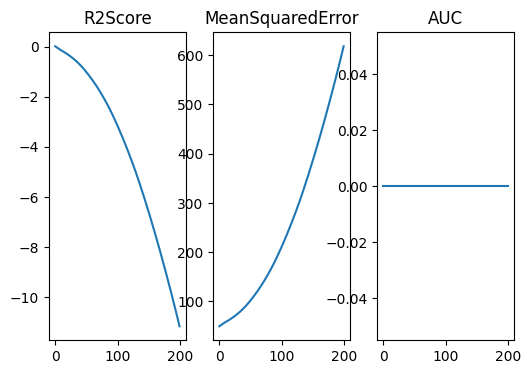

In [ ]:
basic = basicModule(device=device)
basicData = []

optimizer = torch.optim.Adam(basic.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  basic.train()
  optimizer.zero_grad()
  pred = basic(
      hetero_train_data['team_in_match'].x,
      hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_index
  ).T.to(device)
  ground_truth = hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)
  loss = crit(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  basic.eval()
  pred = basic(
      hetero_val_data['team_in_match'].x,
      hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_index
  ).T.to(device)
  ground_truth = hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)

  basicMetric = Metrics(device)
  basicMetric.update(pred.T, ground_truth.T)
  compute = basicMetric.compute()
  basicData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(basicData)

### Linear Module

In [ ]:
inputForLinear = createLinInput(hetero_train_data)
basicLinearData = []

basicLinear = basicLinearModule(inputForLinear.shape[1], device=device) # 2*playerInMatch_dim

optimizer = torch.optim.Adam(basicLinear.parameters(), lr=lr)

total_loss = total_examples = 0
basicLinear.train()
optimizer.zero_grad()
pred = basicLinear(
    inputForLinear
).T.to(device)
ground_truth = hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)
loss = crit(pred, ground_truth)
loss.backward()
optimizer.step()

# validate
basicLinear.eval()
pred = basic(
    hetero_val_data['team_in_match'].x,
    hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_index
).T.to(device)
ground_truth = hetero_val_data['team_in_match', 'result', 'team_in_match'].edge_attr.to(device)

linearMetric = Metrics(device)
linearMetric.update(pred.T, ground_truth.T)
compute = linearMetric.compute()
basicLinearData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

#drawData(basicLinearData)

R2Score: -11.271981239318848
MeanSquaredError: 623.4166870117188
AUC: -0.0


### GCN Module

R2Score: -inf
MeanSquaredError: inf
AUC: -0.0


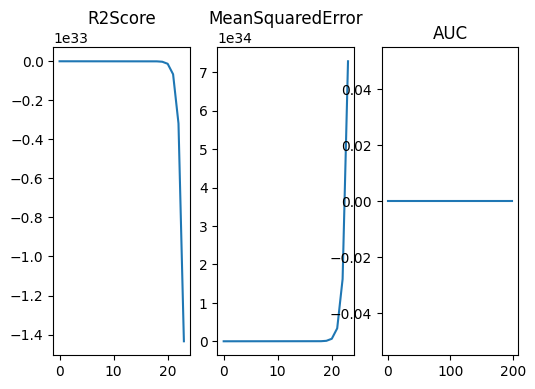

In [ ]:
GCNModule = GCN(embedding_size, hidden_size, out_size, layers=layers, device=device)
gcnData = []

optimizer = torch.optim.Adam(GCNModule.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  GCNModule.train()
  optimizer.zero_grad()

  pred = GCNModule(hetero_train_data).to(device)
  ground_truth = hetero_train_data["team_in_match", "result", "team_in_match"].edge_attr.to(device)
  loss = crit(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  GCNModule.eval()
  pred = GCNModule(hetero_val_data).to(device)
  ground_truth = hetero_val_data["team_in_match", "result", "team_in_match"].edge_attr.to(device)

  gcnMetric = Metrics(device)
  gcnMetric.update(pred.T, ground_truth.T)
  compute = gcnMetric.compute()
  gcnData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(gcnData)

### Homogen GCN Module

R2Score: -inf
MeanSquaredError: inf
AUC: 0.14506027102470398


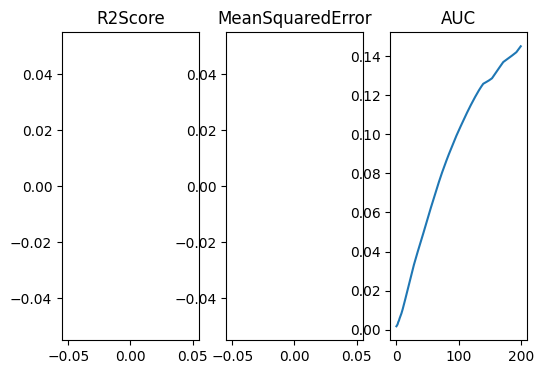

In [ ]:
homoGCNModule = homoGCN(embedding_size, hidden_size, out_size, layers=layers, device=device)
homoGcnData = []

optimizer = torch.optim.Adam(homoGCNModule.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  homoGCNModule.train()
  optimizer.zero_grad()

  pred = homoGCNModule(homo_train_data).to(device)
  ground_truth = homo_train_data.edge_attr.to(device)
  loss = crit(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  homoGCNModule.eval()
  pred = homoGCNModule(homo_val_data).to(device)
  ground_truth = homo_val_data.edge_attr.to(device)

  homoGcnMetric = Metrics(device)
  homoGcnMetric.update(pred.T, ground_truth.T)
  compute = homoGcnMetric.compute()
  homoGcnData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(homoGcnData)

### GAT Module

R2Score: -inf
MeanSquaredError: inf
AUC: 0.0965409129858017


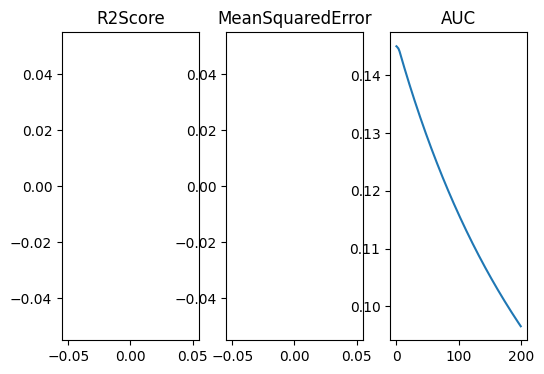

In [ ]:
GATModule = GAT(embedding_size, hidden_size, out_size, layers=layers, device=device)
gatData = []

optimizer = torch.optim.Adam(GATModule.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  GATModule.train()
  optimizer.zero_grad()
  pred = GATModule(hetero_train_data)
  ground_truth = hetero_train_data['team_in_match', 'result', 'team_in_match'].edge_attr
  loss = crit(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  GATModule.eval()
  pred = GATModule(hetero_val_data).to(device)
  ground_truth = hetero_val_data["team_in_match", "result", "team_in_match"].edge_attr.to(device)

  gatMetric = Metrics(device)
  gatMetric.update(pred.T, ground_truth.T)
  compute = gatMetric.compute()
  gatData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(gatData)

### Homogen GAT Module

In [ ]:
homoGATModule = homoGAT(embedding_size, hidden_size, out_size, layers=layers, device=device)
homoGatData = []

optimizer = torch.optim.Adam(homoGATModule.parameters(), lr=lr)

for epoch in range(epochs):
  total_loss = total_examples = 0
  homoGCNModule.train()
  optimizer.zero_grad()

  pred = homoGATModule(homo_train_data).to(device)
  ground_truth = homo_train_data.edge_attr.to(device)
  loss = crit(pred, ground_truth)
  loss.backward()
  optimizer.step()

  # validate
  homoGCNModule.eval()
  pred = homoGATModule(homo_val_data).to(device)
  ground_truth = homo_val_data.edge_attr.to(device)

  homoGatMetric = Metrics(device)
  homoGatMetric.update(pred.T, ground_truth.T)
  compute = homoGatMetric.compute()
  homoGatData.append(compute)

for key in compute:
  print(f"{key}: {compute[key]}")

drawData(homoGatData)